# Token Alignment

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from arsenal import iterview, timeit
from collections import Counter
from IPython.display import HTML

In [8]:
from genparse import CFG, FST, EPSILON, Float, CFGLM, add_EOS, prefix_transducer
from genparse.cfglm import locally_normalize, EOS, pcfg_check
from genparse.util import LarkStuff, hf_tokenizer, about, show_grammar, normalize, bpe2term_approx
from genparse.inference import TraceSWOR

## Accounting for BPE's Tokenization Ambiguity with Transduction 

In [9]:
lark_stuff = LarkStuff(r"""

start: NAME

NAME: /(a|b)*c/

""")
foo = lark_stuff.char_cfg(decay=.1)
foo = locally_normalize(foo)
assert len(foo.trim()) > 0
pcfg_check(foo)

✔ PCFG


In [10]:
foo

Grammar {
  1.0: 0 → NAME
  1.0: NAME → ('NAME', 0)
  1.0: ('NAME', 1) → 
  0.03333333333333333: ('NAME', 0) → a ('NAME', 0)
  0.03333333333333333: ('NAME', 0) → b ('NAME', 0)
  0.9333333333576115: ('NAME', 0) → c ('NAME', 1)
}

In [11]:
foo.cnf.language(3)

key,value
"('c',)",0.9333333333576115
"('b', 'c')",0.031111111111920383
"('b', 'b', 'c')",0.0010370370370640127
"('b', 'a', 'c')",0.0010370370370640127
"('a', 'c')",0.031111111111920383
"('a', 'b', 'c')",0.0010370370370640127
"('a', 'a', 'c')",0.0010370370370640127


In [12]:
lm = CFGLM(add_EOS(foo))

In [13]:
trace = TraceSWOR()
for t in range(15):
    with trace:
        print(t, lm.sample(draw=trace))

0 ['c']
1 ['a', 'c']
2 ['b', 'c']
3 ['a', 'a', 'c']
4 ['b', 'b', 'c']
5 ['b', 'a', 'c']
6 ['a', 'b', 'c']
7 ['a', 'b', 'b', 'c']
8 ['a', 'a', 'a', 'c']
9 ['a', 'a', 'b', 'c']
10 ['b', 'a', 'a', 'c']
11 ['a', 'b', 'a', 'c']
12 ['b', 'b', 'a', 'c']
13 ['b', 'a', 'b', 'c']
14 ['b', 'b', 'b', 'c']


In [14]:
H = hf_tokenizer()
about(H.fst)

states: 369588, trim: 369588


Let's shrink the BPE transducer down to something managable by limiting it alphabet 

In [15]:
b2c = H.fst.prune_to_alphabet(None, foo.V | {''}).renumber
about(b2c)

states: 78, trim: 78


In [16]:
#b2c

We can look at our little language's strings thru the lense of their possible BPE sequences.  Notice that these strings are ambiguously mapped to BPE --- meaning that there are many BPE sequences that would give rise to the same string!

('c',)
total weight of BPE sequences: 1.0



('b', 'c')
total weight of BPE sequences: 2.0


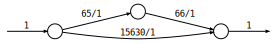


('b', 'b', 'c')
total weight of BPE sequences: 3.0


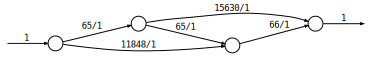


('b', 'a', 'c')
total weight of BPE sequences: 3.0


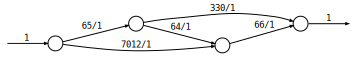


('a', 'c')
total weight of BPE sequences: 2.0


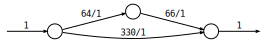


('a', 'b', 'c')
total weight of BPE sequences: 4.0


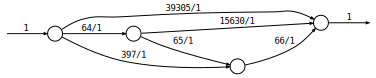


('a', 'a', 'c')
total weight of BPE sequences: 3.0


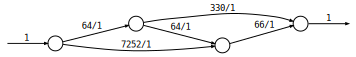

In [17]:
for x in foo.cnf.language(3):
    print(x)
    bpe_x = (b2c @ FST.from_string(x, Float)).trim.project(0).epsremove.trim
    print('total weight of BPE sequences:', bpe_x.total_weight())
    display(bpe_x)
    print()

In [18]:
tmp = (b2c @ foo)
assert len(tmp.trim()) > 0

In [19]:
#tmp.trim().cnf.language(3)

In [20]:
L = 5
c = Float.chart()
for x, w, in tmp.trim().cnf.language(5).items():
    y =  H.tokenizer.decode(x)
    if len(y) > L: continue    
    c[y] += w

In [21]:
ambig = Float.chart({x: (b2c @ FST.from_string(x, Float)).trim.project(0).epsremove.trim.total_weight() for x in c})

In [22]:
ccc = Float.chart()
for x in c:
    ccc[x] = c[x] / ambig[x]

In [23]:
cc = Float.chart()
for x, w in foo.cnf.language(L+2).items():
    if len(x) > L: continue
    cc[''.join(x)] += w
cc

key,value
c,0.9333333333576115
bc,0.031111111111920383
bbc,0.0010370370370640127
bbbc,3.456790123546709e-05
bbbbc,1.1522633745155696e-06
bbbac,1.1522633745155696e-06
bbac,3.456790123546709e-05
bbabc,1.1522633745155696e-06
bbaac,1.1522633745155696e-06
bac,0.0010370370370640127


In [24]:
ccc.assert_equal(cc, tol=1e-20)

In [25]:
#cc.metric(c)

In [26]:
#tmp.trim(bottomup_only=True)

In [27]:
#show_grammar(tmp, showzero=True)

In [28]:
#print(tmp.agenda().__str__(style_value=lambda k, v: (colors.light.red % v) if v > 1.000001 or v < 0 else v))

In [29]:
#for q in c2t.states:      
#    for (a,b), r, w in c2t.arcs(q):
#        print(f'--{a or "ε"}:{b or "ε"}/{w}-->', r)

In [30]:
#{x: v for x,v in tmp.agenda().items() if v > 1.001 or v < 0}

In [31]:
#len(tmp.N - tmp.agenda(tol=1e-40, maxiter=np.inf).trim().keys()), len(tmp.N), len(tmp.agenda(tol=1e-40).trim())

In [32]:
#tmp.cnf.language(4)

In [33]:
#show_grammar(tmp)

In [34]:
p = locally_normalize(tmp, tol=1e-40, maxiter=np.inf).trim()
pcfg_check(p)

✔ PCFG


In [35]:
lm2 = CFGLM(add_EOS(p))

In [36]:
#lm2.sample(verbose=1)

In [37]:
#context = (64,65,6485,39305)
context = (64,65,6485,)

In [38]:
char_context = H.tokenizer.decode(context)
char_context

'ababb'

In [39]:
df = []
for x, w in sorted(normalize(lm2.p_next(context)).items(), key=lambda kv: -kv[1]):
    df.append((x, (H.tokenizer.decode([x]) if x != EOS else EOS), w))
pd.DataFrame(df, columns=['token_id', 'chars', 'prob']).set_index('token_id')

,chars,prob
token_id,,
66,c,0.869821
64,a,0.033333
65,b,0.033333
15630,bc,0.028994
330,ac,0.028994
7252,aa,0.001111
397,ab,0.001111
7012,ba,0.001111
11848,bb,0.001111


In [40]:
Float.chart(normalize(lm.p_next(char_context)))

key,value
b,0.03333333333332973
a,0.03333333333332973
c,0.9333333333333406


## Lexing

In [41]:
lark_stuff = LarkStuff(r"""

start: "SELECT" WS STAR WS "FROM" WS NAME WS EOS

EOS: "</s>"
NAME: /[a-z]+/
STAR: "*"
WS: /[ ]/

""")

In [42]:
foo = lark_stuff.char_cfg(.1)

In [43]:
#foo['NAME'].trim().agenda()

In [44]:
#foo.agenda()

In [45]:
foo = locally_normalize(foo, tol=1e-100).trim()
assert len(foo) > 0

In [46]:
#foo

In [47]:
lm = CFGLM(add_EOS(foo))

In [51]:
trace = TraceSWOR()
for _ in range(15):
   print('mass=', trace.root.mass)
   with trace:
       print(''.join(lm.sample(draw=trace)))

mass= 1.0
SELECT * FROM d </s>
mass= 0.9616809116716195
SELECT * FROM im </s>
mass= 0.9246931843747898
SELECT * FROM m </s>
mass= 0.8863740960560715
SELECT * FROM s </s>
mass= 0.8480550077373533
SELECT * FROM o </s>
mass= 0.8097359194186351
SELECT * FROM x </s>
mass= 0.771416831099917
SELECT * FROM k </s>
mass= 0.7330977427811988
SELECT * FROM t </s>
mass= 0.6947786544624805
SELECT * FROM l </s>
mass= 0.6564595661437623
SELECT * FROM g </s>
mass= 0.6181404778250442
SELECT * FROM n </s>
mass= 0.579821389506326
SELECT * FROM z </s>
mass= 0.5415023011876078
SELECT * FROM j </s>
mass= 0.5031832128688898
SELECT * FROM a </s>
mass= 0.46486412455017184
SELECT * FROM y </s>


In [52]:
cfg = lark_stuff.convert().renumber()

In [53]:
c2t = lark_stuff.transducer(ignore='', decay=.0125); len(c2t.states)

25

The `lark` library will only lex it one way because it has a deterministic semantics for prioritized lexing:

In [54]:
x = 'SELECT * FROM data'

In [55]:
list(lark_stuff.lex(x))

[Token('SELECT', 'SELECT'),
 Token('WS', ' '),
 Token('STAR', '*'),
 Token('WS', ' '),
 Token('FROM', 'FROM'),
 Token('WS', ' '),
 Token('NAME', 'data')]

However, this string can lex many different ways:

In [56]:
ambig = (FST.from_string(x, Float) @ c2t).trim.project(1).epsremove.trim.to_cfg().cnf.language(15)

In [57]:
#ambig

It might be fine to allow ambiguous lexing because very few of the possible lexing options will survive the parser.

In [58]:
for y in ambig:
    v = cfg.prefix_weight(y)   # show all options with a nonzero prefix weight
    if v == 0: continue
    print(v, y)

1.0 ('SELECT', 'WS', 'STAR', 'WS', 'FROM', 'WS', 'NAME')


In [59]:
#((FST.from_string('SELECT', Float) @ c2t) @ P.T @ cfg).trim().cnf.language(15)

In [60]:
#(P.T @ cfg).trim().cnf.language(100)

In [61]:
cfg_t = (c2t.renumber @ cfg).trim()
pcfg_t = locally_normalize(cfg_t, tol=1e-100, maxiter=10_000_000)

In [62]:
pcfg_check(pcfg_t)

✔ PCFG


In [63]:
cfg_t('SELECT * FROM data </s>')

2.117582368135754e-46

In [64]:
cfg_t('SELECT * FROM data </s>')

2.117582368135754e-46

In [65]:
lm = CFGLM(add_EOS(pcfg_t.cnf))

In [66]:
for _ in range(10):
    print(''.join(lm.sample()))

SELECT * FROM xmh </s>
SELECT * FROM o </s>
SELECT * FROM c </s>
SELECT * FROM q </s>
SELECT * FROM e </s>
SELECT * FROM a </s>
SELECT * FROM g </s>
SELECT * FROM l </s>
SELECT * FROM e </s>
SELECT * FROM x </s>


In [67]:
lm.p_next('SELECT * FROM ')

key,value
r,0.03846153846151434
q,0.03846153846151434
v,0.03846153846151434
b,0.03846153846151434
x,0.03846153846151434
l,0.03846153846151434
w,0.03846153846151434
a,0.03846153846151434
g,0.03846153846151434
u,0.03846153846151434


## BPE Basics

In [68]:
hf_tk = hf_tokenizer()
tokenizer = hf_tk.tokenizer

In [69]:
b2c = hf_tk.fst
len(b2c.states)

369588

In [70]:
x = 'SELECT * FROM data'
b = tokenizer.encode(x)
b

[46506, 1635, 16034, 1366]

In [71]:
[tokenizer.decode([bb]) for bb in b]

['SELECT', ' *', ' FROM', ' data']

In [72]:
with timeit('composition'):
    c = FST.from_string(tuple(b), Float) @ b2c
about(c)

states: 31, trim: 30


composition (3.7021 sec)


In [73]:
c.trim

We can build this "transducer" more efficiently

In [74]:
t = bpe2term_approx(tokenizer, tokenizer.encode(x)).epsremove.trim
t

## BPE Ambiguity

In [75]:
with timeit('composition'):
    bs = b2c @ FST.from_string(x, Float)
with timeit('trim'):
    bs.trim
about(bs)

composition (10.0991 sec)


states: 1062324, trim: 172


trim (7.8209 sec)


In [76]:
#bs.trim

The automaton below describes all the BPE sequences that generate the string `x`:

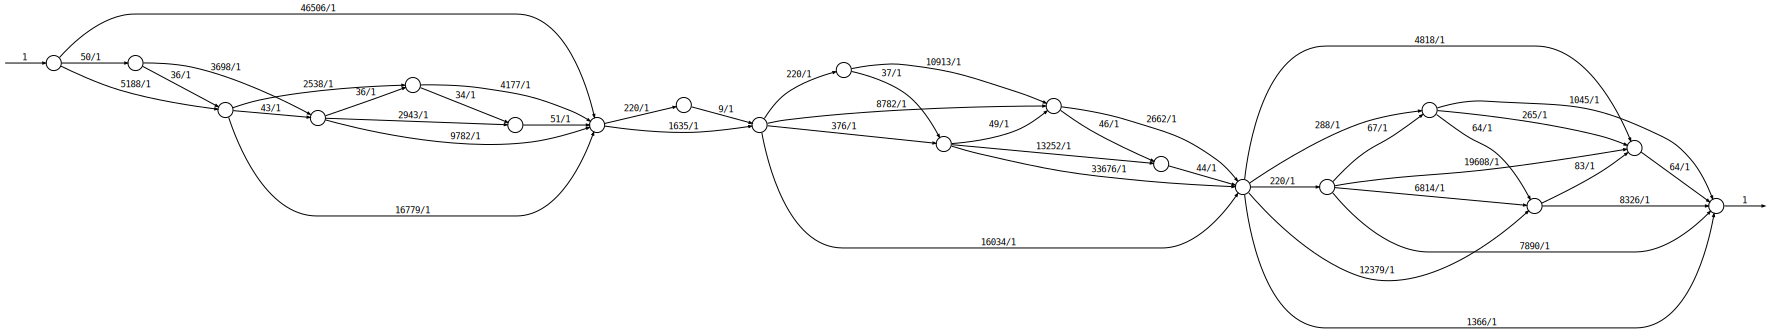

In [77]:
bs.trim.project(0).epsremove.trim

To see all the BPE sequences that generate `x` run the cell below:

In [78]:
#for y in bs.trim.project(0).epsremove.trim.to_cfg().language(10):
#    print(tokenizer.decode(y), y)

## A Basic Alignment Algorithm

In [79]:
from genparse.cfglm import CharAlignedCFGLM

In [80]:
lark_stuff = LarkStuff(r"""
start: "SELECT" WS select_expr WS "FROM" WS from_expr [WS "WHERE" WS bool_condition] [WS "GROUP BY" WS var_list] [WS "ORDER BY" WS orderby_expr] WS EOS
EOS: "</s>"
select_expr: STAR | select_list
bool_condition: bool_expr | "(" bool_condition WS "AND" WS bool_condition ")" | "(" bool_condition WS "OR" WS bool_condition ")"
bool_expr: var "=" value | var ">" value | var "<" value
from_expr: "data"
orderby_expr: var_list WS "ASC" | var_list WS "DESC"
select_list: select_var ("," WS select_var)*
var_list: var ("," WS var)*
select_var: var | "AVG(" var ")" | "MEDIAN(" var ")" | "COUNT(" var ")"
var: "age" | "gender" | "year" | "state_color" | "zipcode" | "vote" | "race_ethnicity"
value: NUMBER | "red" | "blue" | "white" | "black" | "latino" | "republican" | "democrat" | "male" | "female"
STAR: "*"
NUMBER: /\d+/
WS: " "
""")

foo = lark_stuff.char_cfg(.7)
foo = locally_normalize(foo, tol=1e-100).trim()
assert len(foo) > 0
lm = CFGLM(add_EOS(foo))

In [81]:
print(''.join(lm.sample()))

SELECT age FROM data </s>


In [82]:
H = hf_tokenizer()

In [83]:
bpe_lm = CharAlignedCFGLM(lm=lm, words={x for _, x in H.pairs}, eos=H.tokenizer.eos_token)

In [84]:
bpe_lm.p_next('')

key,value
SE,0.3333333333333336
SELECT,0.3333333333333326
S,0.33333333333333387


In [85]:
bpe_lm.p_next('SELECT ')

key,value
year,0.0003095979591655761
ye,0.01685869702636845
y,0.12440475039430289
age,0.006660654820202691
ag,0.03440550413544584
a,0.17772107199186135
rac,5.1493480584126015e-08
race,1.971150069981064e-10
ra,1.34519364255875e-05
r,0.0035141262844413557


In [86]:
ys = bpe_lm.sample(verbose=0)
ys

'SELECT * FROM data </s>'